# Project setup

Import necessary libraries

In [33]:
# System
import os
import shutil

# Image handling
from PIL import Image

# Numerical
import numpy as np
import pandas as pd

# Reproducability
import random
random.seed(42)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [34]:
DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

TRAIN_DIR = os.path.join(DIR, 'CASIA-HWDB_Train/Train/')
TEST_DIR = os.path.join(DIR, 'CASIA-HWDB_Test/Test/')

DATA_DIR = 'data/'

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [35]:
image_classes_train = set(os.listdir(TRAIN_DIR))
image_classes_test = set(os.listdir(TEST_DIR))
print(len(image_classes_train), image_classes_train)
print(len(image_classes_test), image_classes_test)

if image_classes_train == image_classes_test:
    print('The same classes are in each folder')
    image_classes = image_classes_train
else:
    print('The two folders contain different classes')


178 {'午', '起', '个', '杯', '少', '工', '十', '坐', '九', '书', '几', '些', '觉', '店', '开', '猫', '下', '气', '妈', '水', '名', '五', '很', '呢', '什', '零', '椅', '热', '么', '他', '苹', '好', '里', '能', '谁', '我', '你', '在', '喂', '们', '三', '米', '吗', '钱', '对', '出', '亮', '雨', '谢', '欢', '买', '岁', '字', '天', '八', '想', '太', '做', '服', '菜', '七', '四', '说', '爸', '睡', '来', '语', '识', '馆', '月', '回', '喜', '姐', '不', '面', '分', '京', '影', '生', '认', '高', '怎', '衣', '茶', '爱', '租', '一', '友', '饭', '小', '飞', '机', '二', '桌', '打', '读', '住', '上', '现', '和', '家', '写', '商', '块', '东', '漂', '请', '候', '是', '六', '明', '女', '国', '钟', '习', '视', '见', '今', '她', '这', '车', '系', '看', '医', '院', '都', '叫', '狗', '儿', '昨', '同', '后', '汉', '去', '哪', '话', '那', '学', '本', '先', '有', '没', '点', '喝', '中', '期', '日', '西', '老', '客', '关', '校', '朋', '作', '兴', '人', '了', '吃', '听', '会', '前', '果', '站', '年', '再', '子', '样', '星', '冷', '的', '师', '北', '脑', '多', '火', '时', '电', '大'}
178 {'午', '起', '个', '杯', '少', '工', '十', '坐', '九', '书', '几', '些', '觉', '店', '开', '猫', '下', '气', '妈', '水', 

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [36]:
# Remove old data
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)
    
#Create the new directory
os.mkdir(DATA_DIR)

Now let's combine the train and test data into one directory. This is specified by the `DATA_DIR` variable.

In [37]:
# Copy train directory into combined folder
for image_class in image_classes:
    source_path = os.path.join(TRAIN_DIR, image_class)
    destination_path = os.path.join(DATA_DIR, image_class)
    shutil.copytree(source_path, destination_path)

# Count how many images in each class in train set
class_counts = {}
for image_class in image_classes:
    path = os.path.join(DATA_DIR, image_class)
    class_counts[image_class] = len(os.listdir(path))

# Copy all the images in the test directory into combined folder under an consistent name
for image_class in image_classes:
    source_path = os.path.join(TEST_DIR, image_class)
    destination_path = os.path.join(DATA_DIR, image_class)
    
    for filename in os.listdir(source_path):
        class_counts[image_class] += 1
        new_filename = f"{class_counts[image_class]}.png"
        shutil.copy(os.path.join(source_path, filename), os.path.join(destination_path, new_filename))
        

Now lets check how many images we have in each class and see how balanced the classes are.

In [38]:
df_class_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df_class_counts.reset_index(inplace=True)
df_class_counts.columns = ['Character', 'Count']

print(df_class_counts)
print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

    Character  Count
0           午    743
1           起    742
2           个    744
3           杯    743
4           少    741
..        ...    ...
173         多    741
174         火    741
175         时    742
176         电    742
177         大    747

[178 rows x 2 columns]
            Count
count  178.000000
mean   741.292135
std      3.040972
min    721.000000
5%     737.000000
25%    740.000000
50%    741.000000
75%    743.000000
95%    746.000000
max    748.000000


From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [39]:
mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

    Character  Count
25          零    732
61          四    734
69          月    748
109         六    733
148         老    734
166         样    721


As we can see, the imbalance is very minimal. For now we can move on to the next step, and revisit this if the performance of our model is being affected by this imbalance.

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [40]:
# Loop through each subdirectory and file in the directory
for subdir, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        if filename.lower().endswith('.png'):
            # Construct the full path
            file_path = os.path.join(subdir, filename)

            # Open the image
            with Image.open(file_path) as img:
                # Check if the image is not grayscale
                if img.mode != 'L':
                    print(f"{file_path} is not a black and white image.")
        else:
            print("Not a png file: ")

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [41]:
image_sizes = []

# Iterate through all the images and check if any do not have a 1:1 aspect ratio
for subdir, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        file_path = os.path.join(subdir, filename)
        with Image.open(file_path) as img:
            image_sizes.append(img.size[0])
            
            if img.size[0] != img.size[1]:
                print(file_path, img.size)

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 3


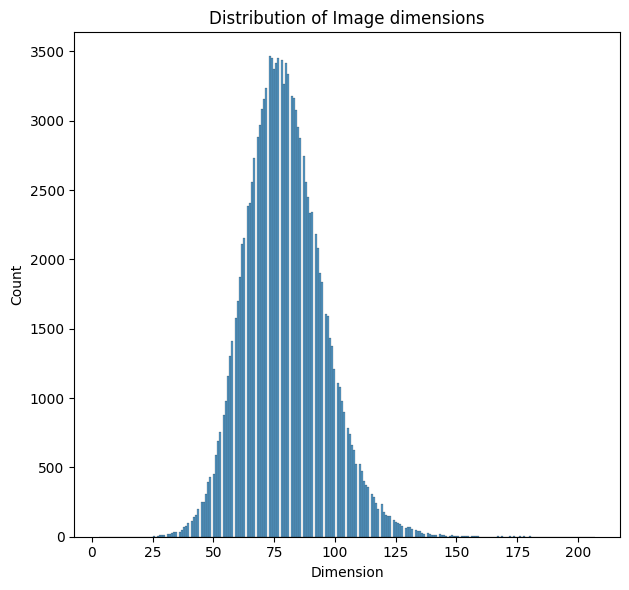

In [42]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(image_sizes)
plt.title('Distribution of Image dimensions')
plt.xlabel('Dimension')
plt.tight_layout()
plt.show()

As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will remove that image.

In [43]:
# Iterate through all the images and resize to a fixed size
for subdir, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        file_path = os.path.join(subdir, filename)
        with Image.open(file_path) as img:
            current_size = img.size
            if img.size[0] < 5:
                os.remove(file_path)
            
            target_size = 48
            
            resized_img = img.resize((target_size, target_size))
            resized_img.save(file_path)

# Data Augmentation

Now that all the images are the same size, we can begin with augmenting the images. This will involve randomly flipping rotating the images to create more data for the model to train on and prevent overfitting.
Note, there are many more augmentation techniques that can be used such as scaling, randomly cropping, randomly erasing, distorting, and blurring, but for now we will only use rotation and flipping.

In [44]:
# How many augmented images should be generated as a percentage of the current
percent_augmented = 0.2 # 0 to 1
augments = [(0, 90), (0, 180), (0, 270), (1, 0), (1, 90), (1, 180), (1, 270)]

# Iterate through all the images and resize to a fixed size
for subdir, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        file_path = os.path.join(subdir, filename)
        with Image.open(file_path) as img:
            if random.random() <= percent_augmented:
                augmented_img = img

                augment = random.choice(augments)

                if augment[0]:
                    augmented_img = augmented_img.transpose(Image.FLIP_LEFT_RIGHT)
                if augment[1]:
                    augmented_img = augmented_img.rotate(augment[1])

                name, extension = filename.rsplit('.', 1)
                save_file_path = os.path.join(subdir, f"{name}.aug.{extension}")

                augmented_img.save(save_file_path)

In [49]:
import glob

png_files = glob.glob(f"{DATA_DIR}/**/*.png", recursive=True)
aug_png_files = glob.glob(f"{DATA_DIR}/**/*.aug.png", recursive=True)

print(f"Number of .png files in the data directory: {len(png_files)}")
print(f"Number of .aug.png files in the data directory: {len(aug_png_files)}")

Number of .png files in all subdirectories of DATA_DIR: 158516
Number of .aug.png files in all subdirectories of DATA_DIR: 26566


# Feature Extraction

In [ ]:
dir = os.path.join(DATA_DIR, '一')